In [10]:
import csv 
import json

csvpath = r'UNFCCC_v26.csv'
jsonpath = r'UNFCCC_v26.json'

convert_csv_into_json(csvpath, jsonpath)


def convert_csv_into_json(csvpath, jsonpath):
    array4json = []
      
    #reading the csv file from csv path
    with (open(csvpath, encoding='utf-8') as csvf): 
        csvReader = csv.DictReader(csvf) 

        rowcount = 0
        for row in csvReader: 
            #Read only Car specific and Total data
            if  row['Pollutant_name'] == 'All greenhouse gases - (CO2 equivalent)' and (row['Sector_name'] == '1.A.3.b.i - Cars'  or row['Sector_name'] == 'Total emissions (UNFCCC)') :
                array4json.append(row)
                print(row['Pollutant_name'])
                rowcount += 1
    with open(jsonpath, 'w', encoding='utf-8') as jsonf: 
        jsonString = json.dumps(array4json, indent=4)
        jsonf.write(jsonString)
          






All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)
All greenhouse gases - (CO2 equivalent)


In [21]:
import psycopg2 

createString = """
CREATE TABLE IF NOT EXISTS GreenHouse_CO2 (
Country_code char(20),
Country	varchar(50),
Format_name	varchar(50),
Pollutant_name	varchar(200),
Sector_code	varchar(50),
Sector_name	varchar(300),
Parent_sector_code	varchar(30),
Unit	varchar(30),
Year	integer,
emissions	numeric, 
Notation varchar(30),
PublicationDate integer,
DataSource varchar(30)
);
"""

insertdata = '''COPY GreenHouse_CO2(Country_code, Country, Format_name, Pollutant_name, Sector_code, Sector_name, Parent_sector_code, Unit, Year, emissions) FROM 'UNFCCC_v26.csv' 
DELIMITER ',' 
CSV HEADER;'''

readdata = '''select count(*) from GreenHouse_CO2;'''


In [22]:
print(createString)
print(insertdata)
print(readdata)


CREATE TABLE GreenHouse_CO2 (
Country_code char(20),
Country	varchar(50),
Format_name	varchar(50),
Pollutant_name	varchar(200),
Sector_code	varchar(50),
Sector_name	varchar(300),
Parent_sector_code	varchar(30),
Unit	varchar(30),
Year	integer,
emissions	numeric, 
Notation varchar(30),
PublicationDate integer,
DataSource varchar(30)
);

COPY GreenHouse_CO2(Country_code, Country, Format_name, Pollutant_name, Sector_code, Sector_name, Parent_sector_code, Unit, Year, emissions) FROM 'UNFCCC_v26.csv' 
DELIMITER ',' 
CSV HEADER;
select count(*) from GreenHouse_CO2;


In [51]:
try :
    dbConnection = psycopg2.connect(
        user = "dap",
        password = "dap",
        host = "192.168.56.30",
        port = "5432",
        database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #dbCursor.execute("drop table GreenHouse_CO2;")
    #dbCursor.execute(createString)
    dbCursor.execute(readdata)
    print (dbCursor.fetchall())
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

[(2080,)]


In [50]:
import csv


try:
    dbConnection = psycopg2.connect(
                            user = "dap",
                            password = "dap",
                            host = "192.168.56.30",
                            port = "5432",
                            database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    #insertString = "INSERT INTO GreenHouse_CO2 VALUES ('{}',"+"'{}',"*8+"'to_number({}, '9999999999.99999')','{}','{}','{}')"
    insertString = "INSERT INTO GreenHouse_CO2 VALUES ('{}'," + "'{}',"*8 + "cast(coalesce(nullif('{}',''),'0') as float),'{}','{}','{}')"

    #print(insertString)
    with open('UNFCCC_v26.csv', 'r') as f:
        reader = csv.reader(f)
        next(reader) # skip the header
        for row in reader:
            #print(insertString.format(*row))
            if  row[3] == 'All greenhouse gases - (CO2 equivalent)' and (row[5] == '1.A.3.b.i - Cars'  or row[5] == 'Total emissions (UNFCCC)') and row[8] != '1985-1987'  :
                dbCursor.execute(insertString.format(*row))
    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error:", dbError)
finally:
    if(dbConnection):
        dbConnection.close()

In [95]:
readCO2Emissions_cars = '''Select Year,  
    sum(emissions) as CarsEmission
    from GreenHouse_CO2
    where Sector_name = '1.A.3.b.i - Cars' and Country_code = 'EUA'
    group by  Year
'''

readCO2Emissions_ALL = '''Select Year,
    sum(emissions) as TotalEmission
    from GreenHouse_CO2
    where Sector_name = 'Total emissions (UNFCCC)' and Country_code = 'EUA'
    group by  Year
'''


try:
    dbConnection = psycopg2.connect(user = "dap",
    password = "dap",
    host = "192.168.56.30",
    port = "5432",
    database = "climate")
    dbConnection.set_isolation_level(0) # AUTOCOMMIT
    dbCursor = dbConnection.cursor()
    dbCursor.execute(readCO2Emissions_cars)
  
    CO2_cars_Only = dbCursor.fetchall(); 

    for i in CO2_cars_Only: 
        print(i) 

    dbCursor.execute(readCO2Emissions_ALL)
    CO2_all_sector = dbCursor.fetchall(); 

    for i in CO2_all_sector: 
        print(i)

    dbCursor.close()
except (Exception , psycopg2.Error) as dbError :
    print ("Error while connecting to PostgreSQL", dbError)
finally:
    if(dbConnection):
        dbConnection.close()


(2008, Decimal('480951.23224'))
(1994, Decimal('413206.13667'))
(2014, Decimal('458349.51112'))
(2010, Decimal('470814.63768'))
(2019, Decimal('483220.2505'))
(1991, Decimal('394510.12301'))
(1996, Decimal('431891.76723'))
(2000, Decimal('457223.42201'))
(2011, Decimal('464550.59445'))
(2017, Decimal('483452.27248'))
(2009, Decimal('476868.11133'))
(2005, Decimal('480541.41953'))
(2013, Decimal('448657.44576'))
(2003, Decimal('477794.44771'))
(2015, Decimal('466627.86469'))
(1993, Decimal('410755.30427'))
(1990, Decimal('388860.35004'))
(1998, Decimal('450957.85969'))
(2007, Decimal('488774.54313'))
(2002, Decimal('473396.40814'))
(2004, Decimal('484375.45057'))
(1997, Decimal('436377.19381'))
(2006, Decimal('482224.75376'))
(2020, Decimal('406560.92397'))
(2001, Decimal('464389.6384'))
(2016, Decimal('477579.92817'))
(1999, Decimal('461226.43213'))
(2012, Decimal('446069.6603'))
(2018, Decimal('480336.43331'))
(1995, Decimal('421372.964'))
(1992, Decimal('407381.07945'))
(2021, Decima

    Year  CarsEmission    AllEmission
0   1990  388860.35004  4866997.59775
1   1991  394510.12301  4761867.85835
2   1992  407381.07945  4611658.68219
3   1993  410755.30427  4533165.14753
4   1994  413206.13667  4509714.05572
5   1995    421372.964  4560147.85956
6   1996  431891.76723  4650978.34252
7   1997  436377.19381  4579674.03966
8   1998  450957.85969  4540461.70646
9   1999  461226.43213   4464183.3389
10  2000  457223.42201   4452021.6243
11  2001   464389.6384  4500256.33936
12  2002  473396.40814  4485727.99169
13  2003  477794.44771  4566353.96585
14  2004  484375.45057  4568722.10312
15  2005  480541.41953  4541881.89835
16  2006  482224.75376  4538039.03394
17  2007  488774.54313  4502767.65157
18  2008  480951.23224  4408412.25575
19  2009  476868.11133  4092959.28975
20  2010  470814.63768  4180741.67268
21  2011  464550.59445  4069866.13577
22  2012   446069.6603  3995310.05734
23  2013  448657.44576  3908576.75698
24  2014  458349.51112  3767739.32618
25  2015  46

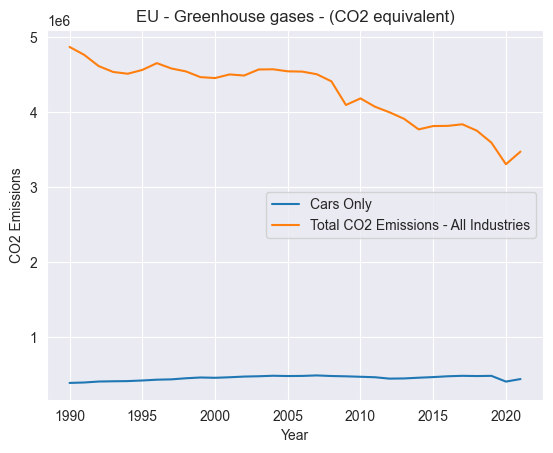

In [148]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(CO2_cars_Only, columns =['Year', 'CarsEmission'])
sorted_df_cars = df.sort_values('Year').reindex()
#print(sorted_df_cars)

df1 = pd.DataFrame(CO2_all_sector, columns =['Year', 'AllEmission'])
sorted_df_all = df1.sort_values('Year').reindex()
#print(sorted_df_all)

df_combined = pd.merge(sorted_df_cars, sorted_df_all, on='Year')

print(df_combined)

plt.plot(df_combined['Year'], df_combined['CarsEmission'], label = 'Cars Only')
plt.plot(df_combined['Year'], df_combined['AllEmission'], label = 'Total CO2 Emissions - All Industries')
plt.title("EU - Greenhouse gases - (CO2 equivalent)")
plt.xlabel('Year')
plt.ylabel('CO2 Emissions')
plt.legend()
plt.show()



C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


1990
[2022 2023 2024 2025 2026 2027 2028 2029 2030 2031]


C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


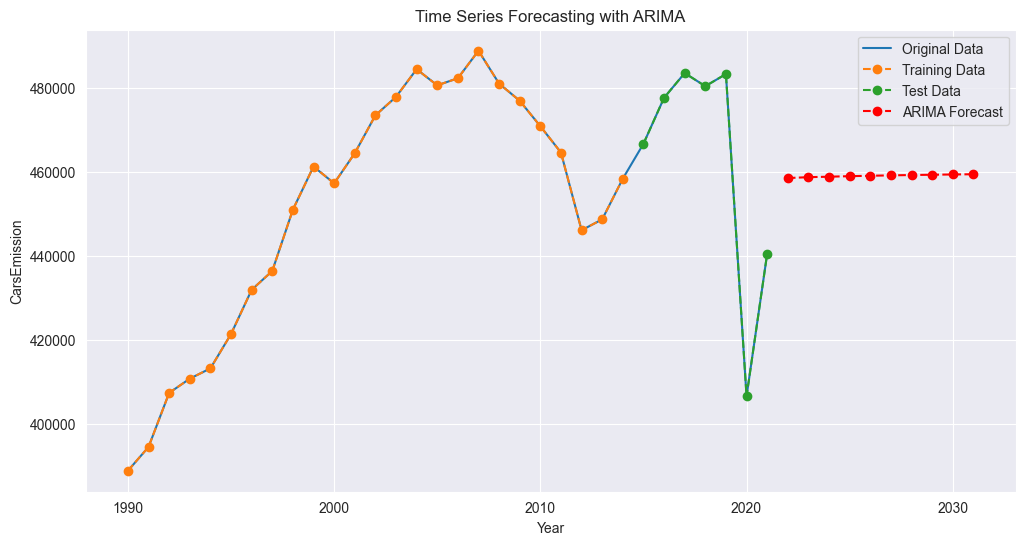

Year
2015    466627.86469
2016    477579.92817
2017    483452.27248
2018    480336.43331
2019     483220.2505
2020    406560.92397
2021    440486.99456
Name: CarsEmission, dtype: object
[458482.74705556 458693.93848727 458804.44546559 458930.56273898
 459030.85011601 459123.55899655 459203.74012345 459275.11005074
 459337.84434092 459393.28960523]


In [176]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA

df_raw = df_combined
#df_raw.set_index("Year", inplace=True)
#print(df_raw)

# Splitting the data into training and testing sets
train_size = int(len(df_raw) * 0.8)
train, test = df_raw[:train_size], df_raw[train_size:]


# Fit ARIMA model
order = (3,1,2)  # ARIMA parameters (p, d, q)
model = ARIMA(train['CarsEmission'].astype(float), order=order)
fit_model = model.fit()

forecast_steps = 10  # Adjust the number of steps as needed

# Forecasting
forecast = fit_model.get_forecast(steps=forecast_steps)
conf_int = forecast.conf_int()
forecast_values = forecast.predicted_mean

print(df_raw.index.min())
# Extend the time index for plotting
forecast_index = np.arange(df_raw.index.max() +1, df_raw.index.max() + forecast_steps + 1)

print(forecast_index)


# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df_raw.index, df_raw['CarsEmission'], label='Original Data')
plt.plot(train.index, train['CarsEmission'], label='Training Data', linestyle='--', marker='o')
plt.plot(test.index, test['CarsEmission'], label='Test Data', linestyle='--', marker='o')

# Plot the ARIMA Forecast along with confidence interval
plt.plot(forecast_index[-forecast_steps:], forecast_values, label='ARIMA Forecast', color='red', linestyle='--', marker='o')

plt.title('Time Series Forecasting with ARIMA')
plt.xlabel('Year')
plt.ylabel('CarsEmission')
plt.legend()
plt.show()

print(test['CarsEmission'])
print(forecast_values.to_numpy())


C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting p

(2, 0, 2)


C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


[388860.35004 394510.12301 407381.07945 410755.30427 413206.13667
 421372.964   431891.76723 436377.19381 450957.85969 461226.43213
 457223.42201 464389.6384  473396.40814 477794.44771 484375.45057
 480541.41953 482224.75376 488774.54313 480951.23224 476868.11133
 470814.63768 464550.59445 446069.6603  448657.44576 458349.51112
 466627.86469 477579.92817 483452.27248 480336.43331 483220.2505
 406560.92397 440486.99456]
[467023.90231766 496137.45113714 519184.20341155 538448.4193948
 555354.29342813 570789.78454251 585308.51889549 599255.67223458
 612846.45530277 626215.04804814 639445.10920548 652588.79846042]


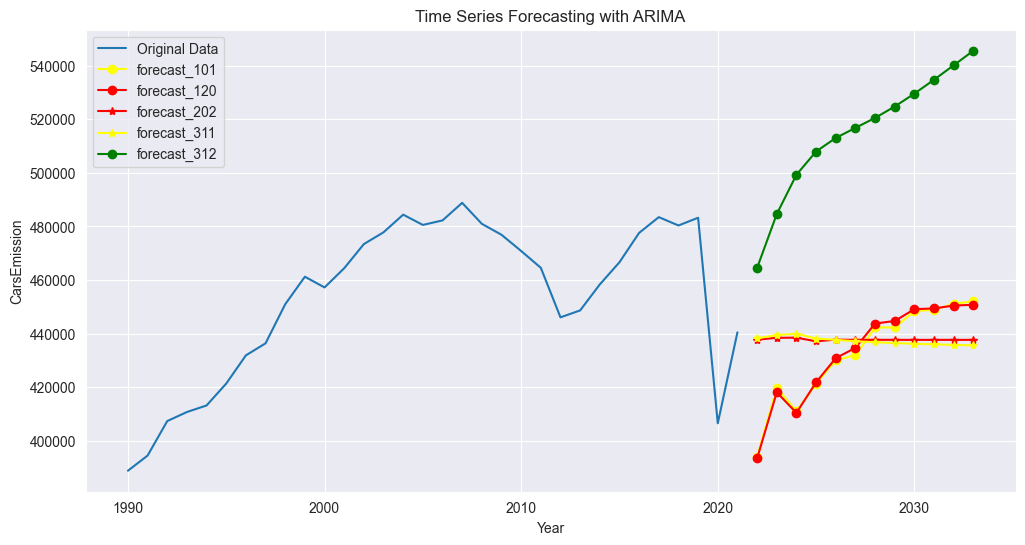

In [322]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

def find_best_arima_params(data, p_values, d_values, q_values):
    best_score, best_params = float("inf"), None

    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p, d, q)
                try:
                    model = ARIMA(data, order=order)
                    results = model.fit()
                    mse = mean_squared_error(data, results.fittedvalues)
                    if mse < best_score:
                        best_score, best_params = mse, order
                except Exception as e:
                    print(f"Error for order {order}: {e}")

    return best_params

# Specify the ranges for p, d, q
p_values = range(0, 3)
d_values = range(0, 2)
q_values = range(0, 3)

emissionValues = df_combined['CarsEmission'].astype(float).values
# Find the best parameters
best_params = find_best_arima_params(emissionValues, p_values, d_values, q_values)

print(best_params)
# Make predictions
forecast_steps = 12  # Adjust the number of steps into the future


order_101= (5,0,0)
# Fit the ARIMA model with the best parameters
final_model_101 = ARIMA(emissionValues, order=order_101)
final_results_101 = final_model_101.fit()
forecast_101 = final_results_101.get_forecast(steps=forecast_steps)

order_120 = (5,0,1)
# Fit the ARIMA model with the best parameters
final_model_120 = ARIMA(emissionValues, order=order_120)
final_results_120 = final_model_120.fit()
forecast_120 = final_results_120.get_forecast(steps=forecast_steps)

order_202 = (5,1,0)
# Fit the ARIMA model with the best parameters
final_model_202 = ARIMA(emissionValues, order=order_202)
final_results_202 = final_model_202.fit()
forecast_202 = final_results_202.get_forecast(steps=forecast_steps)

order_311= (5,1,1)
# Fit the ARIMA model with the best parameters
final_model_311 = ARIMA(emissionValues, order=order_311)
final_results_311 = final_model_311.fit()
forecast_311 = final_results_311.get_forecast(steps=forecast_steps)

order_313= (5,2,0)
# Fit the ARIMA model with the best parameters
final_model_313 = ARIMA(emissionValues, order=order_313)
final_results_313 = final_model_313.fit()
forecast_313 = final_results_313.get_forecast(steps=forecast_steps)

order_312= (5,2,1)
# Fit the ARIMA model with the best parameters
final_model_312 = ARIMA(emissionValues, order=order_312)
final_results_312 = final_model_312.fit()
forecast_312 = final_results_312.get_forecast(steps=forecast_steps)


order_321= (5,3,0)
# Fit the ARIMA model with the best parameters
final_model_321 = ARIMA(emissionValues, order=order_321)
final_results_321 = final_model_321.fit()
forecast_321 = final_results_321.get_forecast(steps=forecast_steps)


order_322= (5,3,1)
# Fit the ARIMA model with the best parameters
final_model_322 = ARIMA(emissionValues, order=order_322)
final_results_322 = final_model_322.fit()
forecast_322 = final_results_322.get_forecast(steps=forecast_steps)


forecast_index = np.arange(df_combined.index.max() +1, df_combined.index.max() + forecast_steps + 1)

print(emissionValues)
print(forecast.predicted_mean)

# Plotting the results
plt.figure(figsize=(12, 6))
plt.plot(df_combined.index, emissionValues, label='Original Data')
#plt.plot(df_combined.index, final_results.fittedvalues, label='Fitted Values', color='green')
plt.plot(forecast_index, forecast_101.predicted_mean, label='forecast_101', color='yellow', marker='o')
plt.plot(forecast_index, forecast_120.predicted_mean, label='forecast_120', color='red', marker='o')
plt.plot(forecast_index, forecast_202.predicted_mean, label='forecast_202', color='red', marker='*')
plt.plot(forecast_index, forecast_311.predicted_mean, label='forecast_311', color='yellow', marker='*')
#plt.plot(forecast_index, forecast_313.predicted_mean, label='forecast_313', color='cyan', marker='o')
plt.plot(forecast_index, forecast_312.predicted_mean, label='forecast_312', color='green', marker='o')
#plt.plot(forecast_index, forecast_321.predicted_mean, label='forecast_321', color='green', marker='*')
#plt.plot(forecast_index, forecast_322.predicted_mean, label='forecast_322', color='cyan', marker='*')
#plt.fill_between(forecast_index, forecast.conf_int()['lower value'], forecast.conf_int()['upper value'], color='red', alpha=0.2)

plt.title('Time Series Forecasting with ARIMA')
plt.xlabel('Year')
plt.ylabel('CarsEmission')
plt.legend()
plt.show()


C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\rames\PycharmProjects\pythonProject\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


ValueError: x and y must have same first dimension, but have shapes (12,) and (32,)

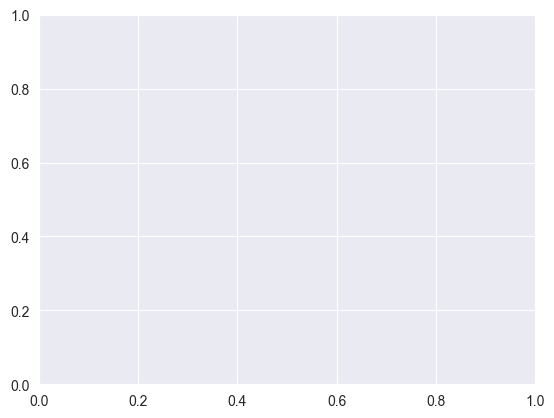

In [364]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from math import sqrt

values_for_plot = df_combined['CarsEmission'].values

#2020 and 2021 CO2 emission values are low during Covid hance using 2019 data for forecasting
values_for_forecast = df_combined
values_for_forecast.loc[2020] = values_for_forecast.loc[2019] 
values_for_forecast.loc[2021] = values_for_forecast.loc[2019] 

# Fit Exponential Smoothing model
model = ExponentialSmoothing(values_for_forecast['CarsEmission'].astype(float),  trend='add', seasonal=None)
fit_model = model.fit()

# Forecasting
forecast_steps = 12
forecast = fit_model.forecast(steps=forecast_steps)

forecast_index = np.arange(df_combined.index.max() +1, df_combined.index.max() + forecast_steps + 1)

# Plotting the results
plt.plot(forecast_index,  values_for_plot, label='Original Data')
plt.plot(forecast_index, forecast, label='Holt-Winters Forecast', color='red')
plt.title('Exponential Smoothing Forecasting')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend()
plt.show()

# Evaluate the model
mse = mean_squared_error(df['values'], fit_model.fittedvalues)
rmse = sqrt(mse)
print(f'Root Mean Squared Error (RMSE): {rmse}')
